Group 10:

* Noah Pichler - k12011672
* Staltner Thomas - k51821123
* Gerald Weglehner - k11805993

# Project Overview
In this project, an object detection running in realtime using YOLO in combination with a subset off the COCO dataset is realised.

Directory Structure:

-datasets &emsp; (should be downloaded by the notebook) <br>
--coco <br>
---annotations <br>
---images <br>
---labels <br>
---old_labels <br>
---train-val-annotations <br>

-runs &emsp; (generated during training, includes all plots for evaluation)<br>
--detect <br>
---train <br>
----weights   &emsp; (here are the model weights) <br>

-assignment_1.ipynb   &emsp;(main skript, should be able to run from top to bottom) <br>
-coco_av.yaml         &emsp;(settings for training, no environment file) <br>
-out.mp4         &emsp;(out test video) <br>
-yolov8n.pt           &emsp;(original yolo weights, only needed for last cell) <br>


# Set up
This notebook basically is structured to run on any machine as imports are realised directly in the notebook's top section and is tested with following machines:
* Macbook Pro running Jupyter in venv with Python 3.11.8
* Ubuntu 20.4 with RTX 3070

# Imports

In [10]:
## Load modules
!pip install pycocotools
!pip install ultralytics
!pip install torch torchvision
!pip install scikit-image
!pip install opencv-python

In [3]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from ultralytics import YOLO
import shutil
import random
import matplotlib.patches as patches
import json
from tqdm import tqdm

os.environ['WANDB_DISABLED'] = 'true'

## Define proper model of pretrained catalogue

[Model Catalogue](https://docs.ultralytics.com/models/)

Here, we define some global parameters used for learning and setup.

In [4]:
## Global variables
YOLO_PRETRAINED_MODEL = 'yolov8n.pt'
YOLO_TRAINED_MODEL = './finetuned/yolov8n.pth'
BATCH_SIZE = 32
NUM_TRAIN_EPOCHS = 20
NUM_IMAGES_TRAIN = 1000000
NUM_IMAGES_VAL = NUM_IMAGES_TRAIN
WORKERS=4
TRAIN_CATS = {'person': 0, 'bicycle': 1, 'car': 2, 'motorcycle': 3, 'bus': 4, 'train': 5, 'truck': 6}
VIDEO_PATH = "./out.mp4"

## Helper Methods

Define useful helper methods in this section.

In [5]:
def is_colab_env():
  return ('google.colab' in str(get_ipython()))

# Dataset
We'll use following commands to load all needed COCO files to the current directory.

In [14]:
from ultralytics.utils.downloads import download
from pathlib import Path
if os.path.exists('./datasets/coco'):
    print("COCO dataset already downloaded")
else:
  # Download labels
  segments = True  # segment or box labels
  dir = Path("./datasets/coco")  # dataset root dir
  url = 'https://github.com/ultralytics/yolov5/releases/download/v1.0/'
  urls = [url + ('coco2017labels-segments.zip' if segments else 'coco2017labels.zip')]  # labels
  download(urls, dir=dir.parent)
  # Download data
  urls = ['http://images.cocodataset.org/zips/train2017.zip',  # 19G, 118k images
          'http://images.cocodataset.org/zips/val2017.zip',  # 1G, 5k images
          'http://images.cocodataset.org/zips/test2017.zip']  # 7G, 41k images (optional)
  download(urls, dir=dir / 'images', threads=3)

COCO dataset already downloaded


Next, we'll define additional annotations used for analysis of the dataset. Therefore, we download the annotations directly and unzip them to the *datasets* folder for later access

In [15]:
if not os.path.exists('./datasets/coco/train-val-annotations'):
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
  !unzip annotations_trainval2017.zip
  !mv annotations ./datasets/coco/train-val-annotations
  !rm annotations_trainval2017.zip

Next, we'll create backup files for all textfile used for training later as we might just use a subset of the provided images.

In [16]:
if not os.path.exists('./datasets/coco/val2017_orig.txt'):
    shutil.copyfile('./datasets/coco/val2017.txt', './datasets/coco/val2017_orig.txt')

if not os.path.exists('./datasets/coco/train2017_orig.txt'):
    shutil.copyfile('./datasets/coco/train2017.txt', './datasets/coco/train2017_orig.txt')

if not os.path.exists('./datasets/coco/test-dev2017_orig.txt'):
    shutil.copyfile('./datasets/coco/test-dev2017.txt', './datasets/coco/test-dev2017_orig.txt')

### Get access to annotations

Next, we'll get access to the provided annotations to access them later.

In [17]:
val_annotations_path = './datasets/coco/annotations/instances_val2017.json'
val_coco = COCO(val_annotations_path)
val_img_ids = val_coco.getImgIds()
# val_img_files = [val_coco.loadImgs(img_id)[0]['file_name'] for img_id in val_img_ids]
# print(val_img_files[0])

train_annotations_path = './datasets/coco/train-val-annotations/instances_train2017.json'
train_coco = COCO(train_annotations_path)
train_img_ids = train_coco.getImgIds()
# train_img_files = [train_coco.loadImgs(img_id)[0]['file_name'] for img_id in train_img_ids]
# print(train_img_files[0])

loading annotations into memory...
Done (t=0.23s)


creating index...
index created!
loading annotations into memory...
Done (t=7.48s)
creating index...
index created!


# Analyse COCO Dataset

First we'll have a look at the provided categories and sub-categories provided by the COCO dataset.

In [18]:
# display COCO categories and supercategories
cats = val_coco.cats.values()
print(f'Number of categories: {len(cats)}')
print('COCO categories: \n{}\n'.format(' '.join([cat['name'] for cat in cats])))

nms = set([cat['supercategory'] for cat in cats])
print(f'Number of supercategories: {len(nms)}')
print('COCO supercategories: \n{}'.format(' '.join(nms)))

Number of categories: 80
COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

Number of supercategories: 12
COCO supercategories: 
furniture accessory vehicle indoor person sports kitchen animal food outdoor electronic appliance


Here, we'll pick a random image for some more insight later. As it can be seen, we just consider categories of persons and cars therefore.

In [19]:
# get all images containing given categories, select one at random
catIds = train_coco.getCatIds(catNms=['person', 'car']);
imgIds = train_coco.getImgIds(catIds=catIds );
print(f'Number of considered image id\'s: {len(imgIds)}')
img = train_coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

Number of considered image id's: 8519


Earlier, we created a backup of the textfiles considered for training the model.

Now, we are going to pick images of interest and add a randomness as we strict the training data to `NUM_IMAGES_TRAIN` images and validation data to `NUM_IMAGES_VAL`.

Considered categories are picked in the context of street objects and are defined on top of this notebook.

We remove every annotation except the considere categories and remove every image from the dataset with no remaining annotations.

We also exclude images with only person labels and no co-occurence of other categories, otherwise we would have a heavily skewed training set with a small subset of motor vehicles images. 

After this, we have created following files which then are used for training/validating the model.
* ./datasets/coco/train2017.txt
* ./datasets/coco/val2017.txt

In [20]:
from ultralytics.data.converter import coco80_to_coco91_class
mapping = coco80_to_coco91_class()

def update_labels(path, dir= os.path.join(os.getcwd(), 'datasets', 'coco', 'old_labels')):
    label_path = os.path.join(dir, 
                              os.path.basename(os.path.dirname(path)) , 
                              os.path.basename(path).replace('.jpg', '.txt'))
    # read old labels
    with open(label_path, 'r') as file:
        new_labels = []
        for line in file.readlines():
            label = line.split(' ')
            cat = train_coco.cats[mapping[int(label[0])]]
            # overwrite label or remove OOV annotations
            try:
                new_idx = TRAIN_CATS[cat['name']]
                label[0] = str(new_idx)
                new_labels.append(' '.join(label))
            except KeyError:
                continue
    # write new labels
    if len(new_labels) != 0:
        label_path = label_path.replace('old_labels', 'labels')
        if not os.path.exists(os.path.dirname(label_path)):
            os.makedirs(os.path.dirname(label_path))
        with open(label_path, 'w') as file:
            file.write('\n'.join(new_labels))

In [21]:
if not os.path.exists('./datasets/coco/old_labels'):
    os.rename('./datasets/coco/labels', './datasets/coco/old_labels')

    # Train Images
    paths = []
    cats = list(TRAIN_CATS.keys())
    cats.pop(0) # remove person
    for cat in cats:
        catIds = train_coco.getCatIds(catNms=cat)
        imgIds = train_coco.getImgIds(catIds=catIds )
        imgs = train_coco.loadImgs(imgIds)
        for img in imgs:
            paths.append(f'./images/train2017/{img["file_name"]}')

    paths_unique = set(paths)
    print(f'Number of possible training images: {len(train_img_ids)}')
    i=0
    with open('./datasets/coco/train2017.txt', 'w') as f:
        for path in tqdm(paths_unique):
            # random sample subset
            rand = random.randint(0, len(paths_unique))
            if rand < NUM_IMAGES_TRAIN:
                try:
                    update_labels(path)
                except ValueError:
                    continue              # Skip images with no annotations
                f.write(f"{path}\n")
                i+=1

    print(f'Number of training images: {i}')

    # Validation Images
    paths = []
    for cat in cats:
        catIds = val_coco.getCatIds(catNms=cat)
        imgIds = val_coco.getImgIds(catIds=catIds )
        imgs = val_coco.loadImgs(imgIds)
        for img in imgs:
            paths.append(f'./images/val2017/{img["file_name"]}')

    paths_unique = set(paths)
    print(f'Number of possible validation images: {len(val_img_ids)}')
    i = 0
    with open('./datasets/coco/val2017.txt', 'w') as f:
        for path in paths_unique:
            rand = random.randint(0, len(paths_unique))
            if rand < NUM_IMAGES_VAL:
                try:
                    update_labels(path)
                except ValueError:
                    continue              # Skip images with no annotations
                f.write(f"{path}\n")
                i+=1

    print(f'Number of validation images: {i}')

Next, we'll get more insight to one particular image of the validation set (does not matter if it is chosen from the training or validation set).

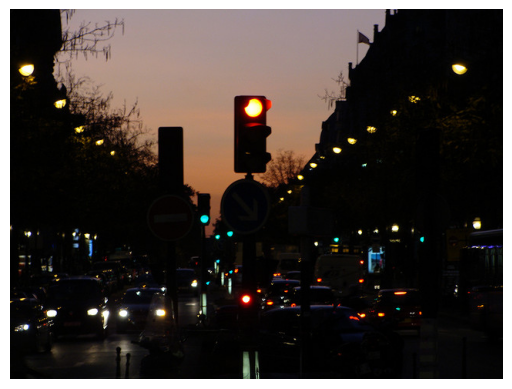

In [22]:
# load and display image
catIds = train_coco.getCatIds(catNms="car")
imgIds = train_coco.getImgIds(catIds=catIds)
img = train_coco.loadImgs(imgIds)[0]
I = io.imread(f'./datasets/coco/images/train2017/{img["file_name"]}')
plt.axis('off')
plt.imshow(I)
plt.show()

Next, we'll have a look at the same image with overlayed annotations.

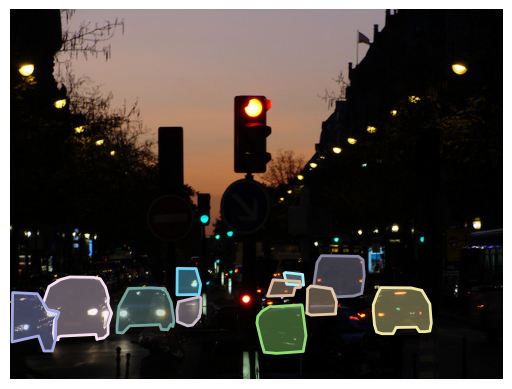

In [23]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = train_coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = train_coco.loadAnns(annIds)
train_coco.showAnns(anns)

Next, we will get the bounding boxes

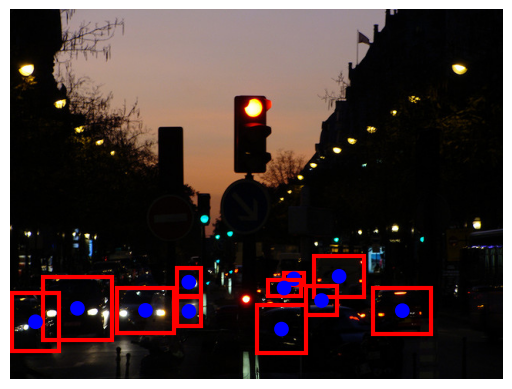

In [24]:
anns = train_coco.loadAnns(annIds)

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
plt.axis('off')
ax.imshow(I)

# Create a Rectangle patch
for annotation in anns:
    bbox = annotation['bbox']
    start = (bbox[0], bbox[1])
    width = bbox[2]
    height = bbox[3]
    center = (bbox[0] + width/2, bbox[1] + height/2)
    rect = patches.Rectangle(start, width, height, linewidth=3, edgecolor='r', facecolor='none')
    center = patches.Circle(center, radius=5, linewidth=5, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.add_patch(center)

# Display the image
plt.show()

And we have a look at the raw data of the image as well as a histogram of the given image.

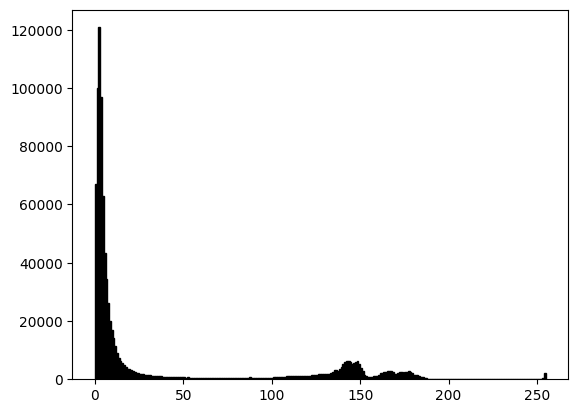

In [25]:
img = np.asarray(Image.open(f'./datasets/coco/images/train2017/{img["file_name"]}'))
plt.hist(img.ravel(), bins=range(256), fc='k', ec='k')
plt.show()

## Training Data Class Distribution

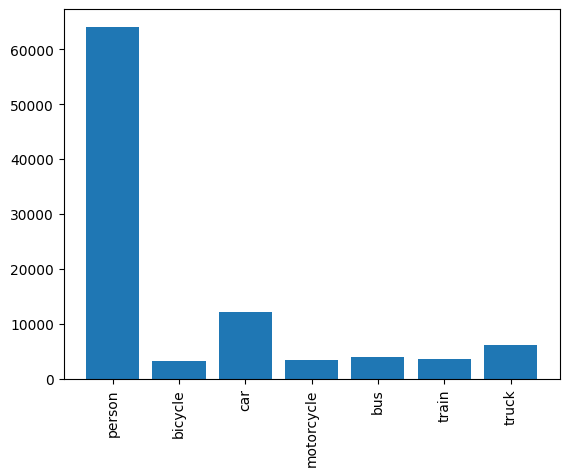

In [26]:
category_list = []
category_quantity = []
for c in TRAIN_CATS.keys():
    category_list.append(c)
    category_quantity.append(len(train_coco.getImgIds(catIds=train_coco.getCatIds(catNms=[c]))))
    # print(f'{c}: {len(train_coco.getImgIds(catIds=train_coco.getCatIds(catNms=[c])))}')

plt.bar(category_list, category_quantity)
plt.xticks(rotation=90);

# Training

Next, we are going to train our model on a subset of the given images considering just the categories of interest (as it can be seen on top of this notebook).

For training, we use following parameters:
* epochs = 20
* batch = 32
* device is set to GPU if possible

We apply some classic data augmentation for images to train on a more diverse training set. The values are choosen to keep a realistic view of the world (eg. no upside down)

Following [data augmentation](https://docs.ultralytics.com/modes/train/#augmentation-settings-and-hyperparameters) is applied for training:
* degrees -> Rotates the image randomly within the specified degree range
* fliplr -> Flips the image l/r with a given probability
* translate -> Translates the image horizontally and vertically by a fraction of the image size

In [27]:
from ultralytics import YOLO

# Run the model on GPU if it is available
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

# Build a YOLOv9c model from pretrained weight
model = YOLO(YOLO_PRETRAINED_MODEL)

# Display model information (optional)
model.info()

# Shift to GPU if possible
model.to(device)

# Train the model on the COCO example dataset for 100 epochs
# results = model.train(data='coco8.yaml', epochs=10, imgsz=640, )
results = model.train(data='coco_av.yaml', epochs=NUM_TRAIN_EPOCHS, workers=WORKERS, imgsz=640, batch=BATCH_SIZE, device=device, degrees=20, fliplr=0.25, translate=0.25)

YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs


New https://pypi.org/project/ultralytics/8.1.29 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco_av.yaml, epochs=20, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=4, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

train: Scanning /home/noah/OneDrive/AI/Autonomous Vehicles/Assignment1/datasets/coco/labels/train2017.cache... 22743 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22743/22743 [00:00<?, ?it/s]
val: Scanning /home/noah/OneDrive/AI/Autonomous Vehicles/Assignment1/datasets/coco/labels/val2017.cache... 993 images, 0 backgrounds, 0 corrupt: 100%|██████████| 993/993 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.84G      1.349        1.9       1.23        199        640: 100%|██████████| 711/711 [02:03<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.68it/s]


                   all        993       6882      0.576      0.414      0.434      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.34G      1.413      1.553      1.284        291        640: 100%|██████████| 711/711 [01:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.00it/s]


                   all        993       6882      0.601      0.439      0.481      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.86G      1.423      1.505      1.294        263        640: 100%|██████████| 711/711 [01:57<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.08it/s]

                   all        993       6882      0.621      0.419      0.474      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.79G      1.417      1.469      1.294        174        640: 100%|██████████| 711/711 [01:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.08it/s]

                   all        993       6882      0.674      0.453      0.519      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.54G      1.396      1.425      1.283        298        640: 100%|██████████| 711/711 [01:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.96it/s]


                   all        993       6882      0.615      0.482      0.532      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.74G      1.374      1.382      1.269        345        640: 100%|██████████| 711/711 [01:59<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.48it/s]


                   all        993       6882      0.667      0.488      0.552      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.56G      1.352      1.343      1.255        244        640: 100%|██████████| 711/711 [01:56<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.72it/s]


                   all        993       6882      0.647      0.501      0.568      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.46G      1.334      1.316      1.243        330        640: 100%|██████████| 711/711 [01:56<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.61it/s]

                   all        993       6882      0.692      0.504      0.579      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.83G      1.322      1.288      1.234        180        640: 100%|██████████| 711/711 [01:56<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.85it/s]


                   all        993       6882      0.654      0.512      0.576      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.25G      1.303      1.259      1.226        253        640: 100%|██████████| 711/711 [01:57<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


                   all        993       6882      0.692      0.533      0.597      0.395
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.95G      1.342       1.24      1.252        125        640: 100%|██████████| 711/711 [01:54<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.15it/s]

                   all        993       6882      0.681      0.537      0.601      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.58G      1.326      1.207       1.24        106        640: 100%|██████████| 711/711 [01:54<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.10it/s]

                   all        993       6882      0.704      0.546      0.616      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.54G      1.312      1.184      1.233        151        640: 100%|██████████| 711/711 [01:53<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.24it/s]

                   all        993       6882      0.694      0.533      0.611      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.67G      1.303      1.163      1.224        184        640: 100%|██████████| 711/711 [01:54<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.86it/s]

                   all        993       6882      0.713      0.555      0.627       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.69G      1.284      1.141      1.214        139        640: 100%|██████████| 711/711 [01:53<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.91it/s]

                   all        993       6882      0.735      0.548      0.629      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.79G      1.274      1.119      1.207        115        640: 100%|██████████| 711/711 [01:54<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.07it/s]

                   all        993       6882      0.724      0.559      0.636      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.77G      1.257      1.097      1.197        140        640: 100%|██████████| 711/711 [01:54<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.14it/s]

                   all        993       6882      0.721      0.566      0.644      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.61G      1.246       1.08      1.189        146        640: 100%|██████████| 711/711 [01:46<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.17it/s]

                   all        993       6882      0.707      0.578      0.644      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.56G      1.236       1.06      1.182        190        640: 100%|██████████| 711/711 [01:46<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.56it/s]

                   all        993       6882      0.706      0.591      0.654      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.56G      1.225      1.042      1.174        109        640: 100%|██████████| 711/711 [01:45<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        993       6882      0.733      0.576      0.657      0.449



20 epochs completed in 0.666 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.10.11 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3070, 7971MiB)
Model summary (fused): 168 layers, 3007013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.29it/s]


                   all        993       6882      0.731      0.576      0.657      0.449
                person        993       3396      0.759      0.588      0.676      0.416
               bicycle        993        314      0.675      0.416      0.493      0.279
                   car        993       1918       0.66      0.551      0.605      0.385
            motorcycle        993        367      0.759        0.6      0.691      0.438
                   bus        993        283      0.819      0.687      0.774       0.63
                 train        993        190      0.845      0.789      0.874      0.673
                 truck        993        414      0.603      0.399      0.486      0.325
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving runs/detect/train2/predictions.json...

Evaluating pycocotools mAP using runs/detect/train2/predictions.json and /home/noah/OneDrive/AI/Autonomous Vehicles/Assignment1/datasets/coco/annotations/insta

# Training Results

We logged after each epoch the average training loss, as well as the loss and differnt metrics off the validation set.

## Loss & Metric

The losses are: (lower is better)

  * box_loss - YOLOs "Intersection over Union"-based Loss
  * cls_loss - YOLOs classification loss (eg. cross-entropy loss)
  * dfl_loss - YOLOs Distribution Focal Loss (is used for bounding box regression)

The metric are: (higher is better)

  * Precision - amount of relevant item that are retrieved
  * Recall - amount of retrieved item that are relevant
  * mAP50 - mean precision over all classes at a threshold of 0.5
  * mAP50-95 - the mean of the mAP with a threshold between 0.5-0.95 

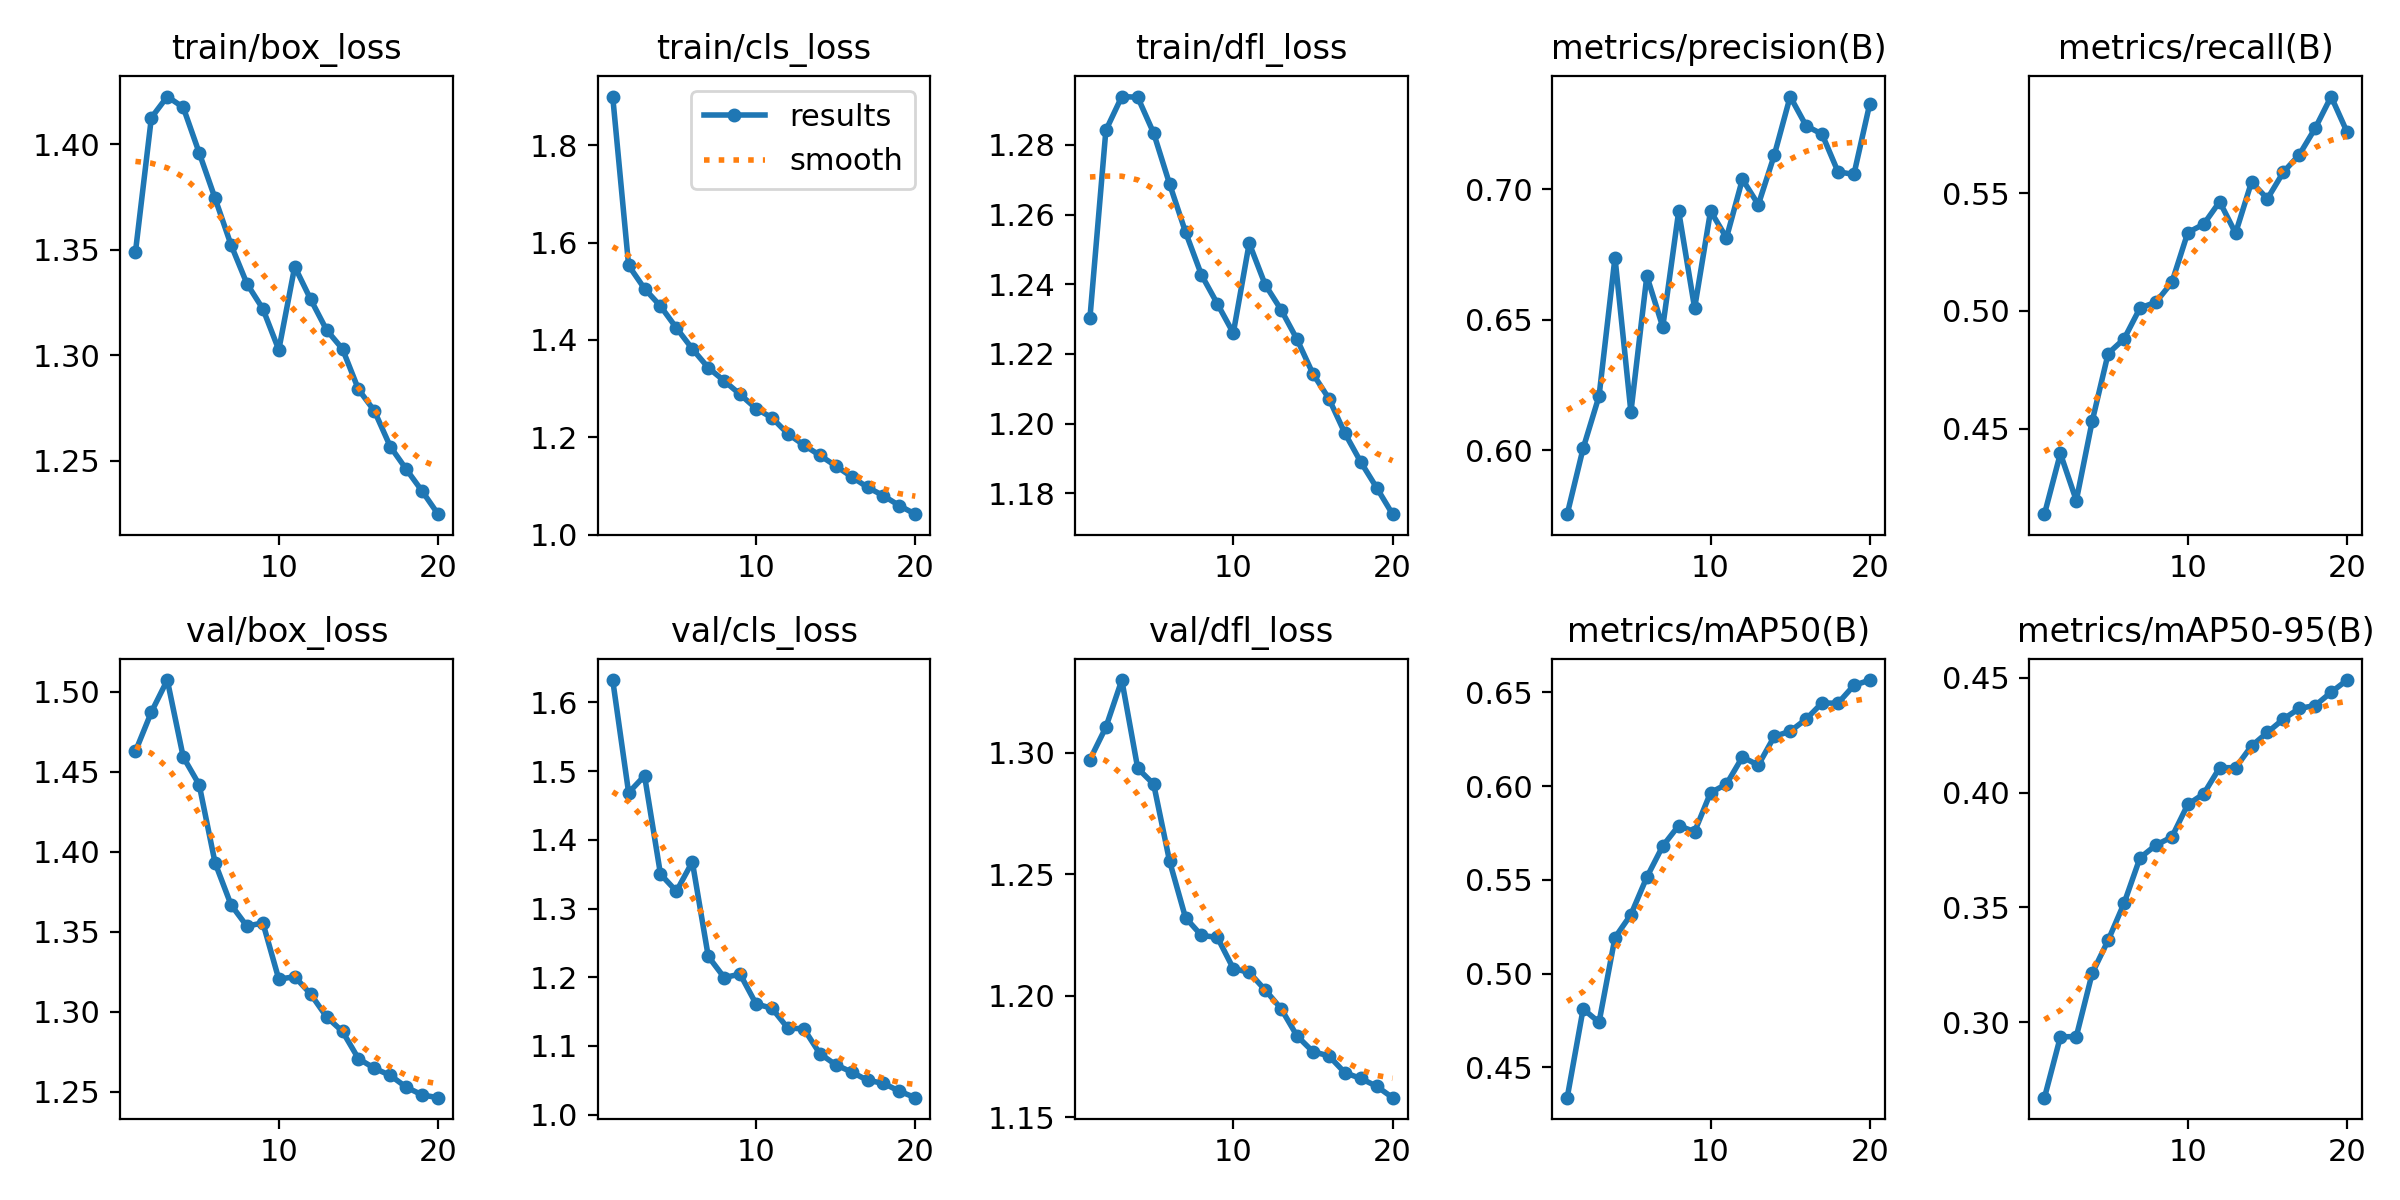

In [8]:
%matplotlib inline
import matplotlib
from ultralytics.utils.plotting import plot_results
import matplotlib.image as mpimg
from IPython.display import display, Image

# to change to new training results: train -> train1
results_dir = os.path.join("runs", "detect", "train")

img = Image(os.path.join(results_dir, "results.png"))
img.width = 1200
display(img)

We can see on above curves that the model train nicely over all 20 epochs. The model even looks not completely converged, but we decided to stop at 20 epochs to conserve part of the information from the pretraining at to keep some degree of generalization.

## PR Curve

To have a better grasp class differences and the connection of the decision boundary and performance, we plotted a precision-recall curve for each class.

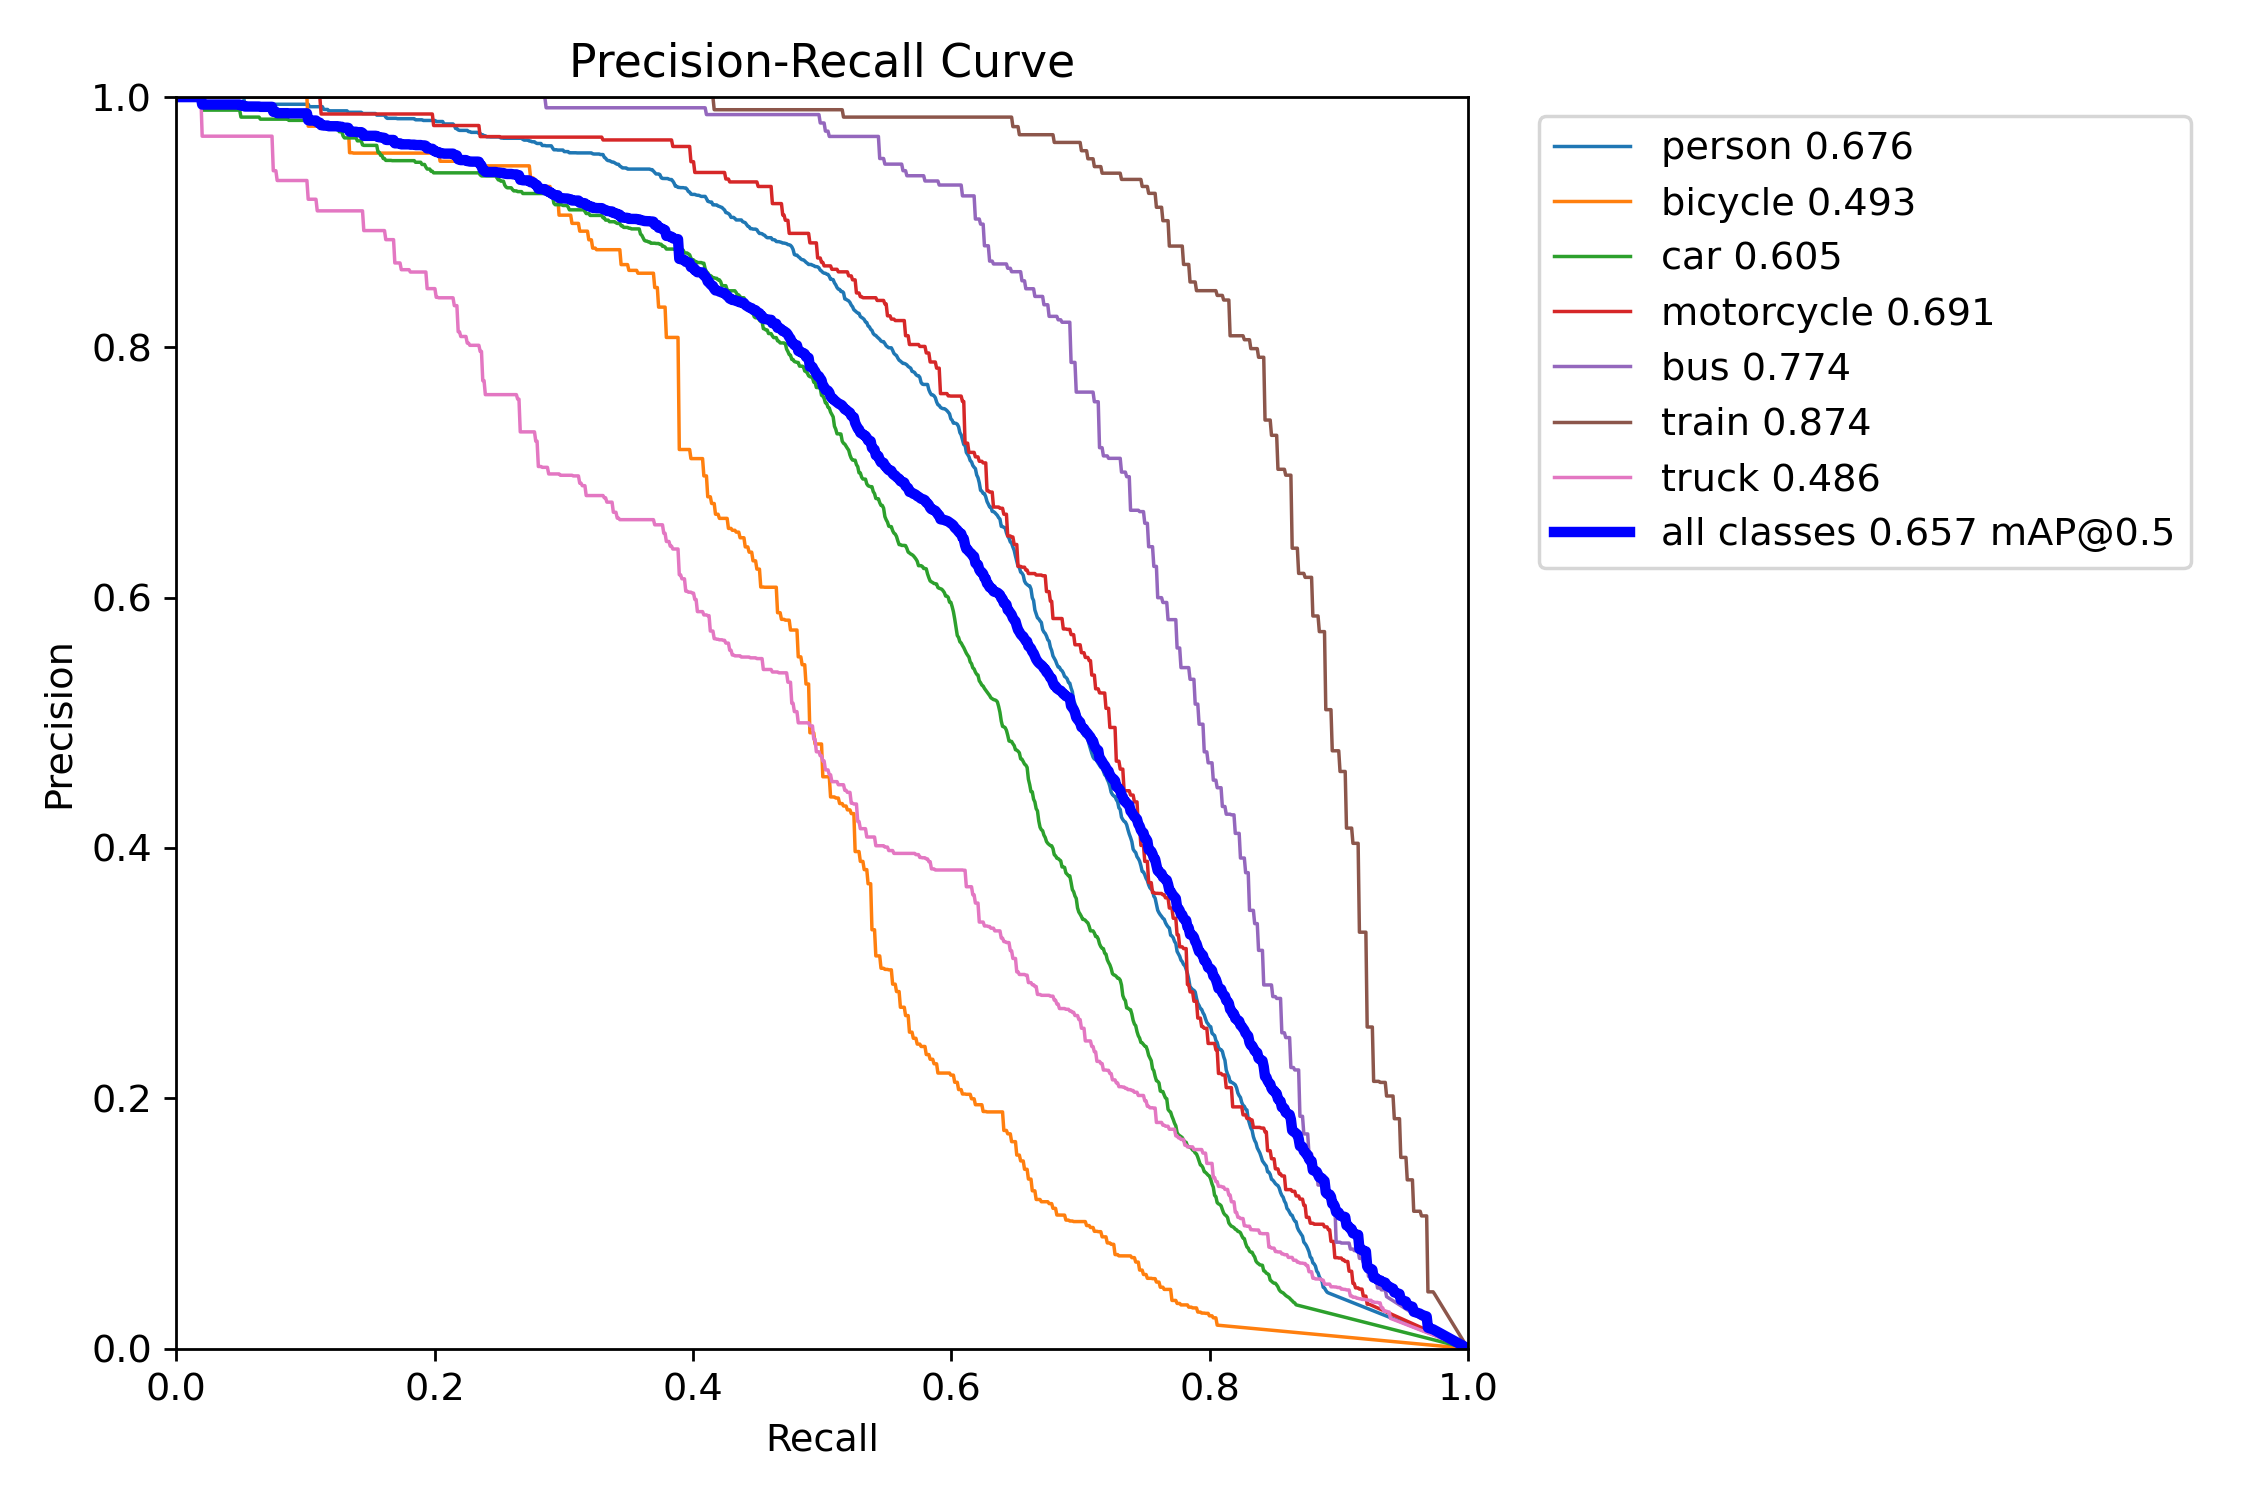

In [29]:
img = Image(os.path.join(results_dir, "PR_curve.png"))
img.width = 800
display(img)

While the model performs worst for trucks, predictions for bicycles seem to include a lot of false positives at lower decision boundaries.  The model excels for detection of busses and trains.

## Confusion Matrix

In the confusion matrix we plot the prediction of the classes to it's true values, to get an insight on the seperation of the class predicitons.

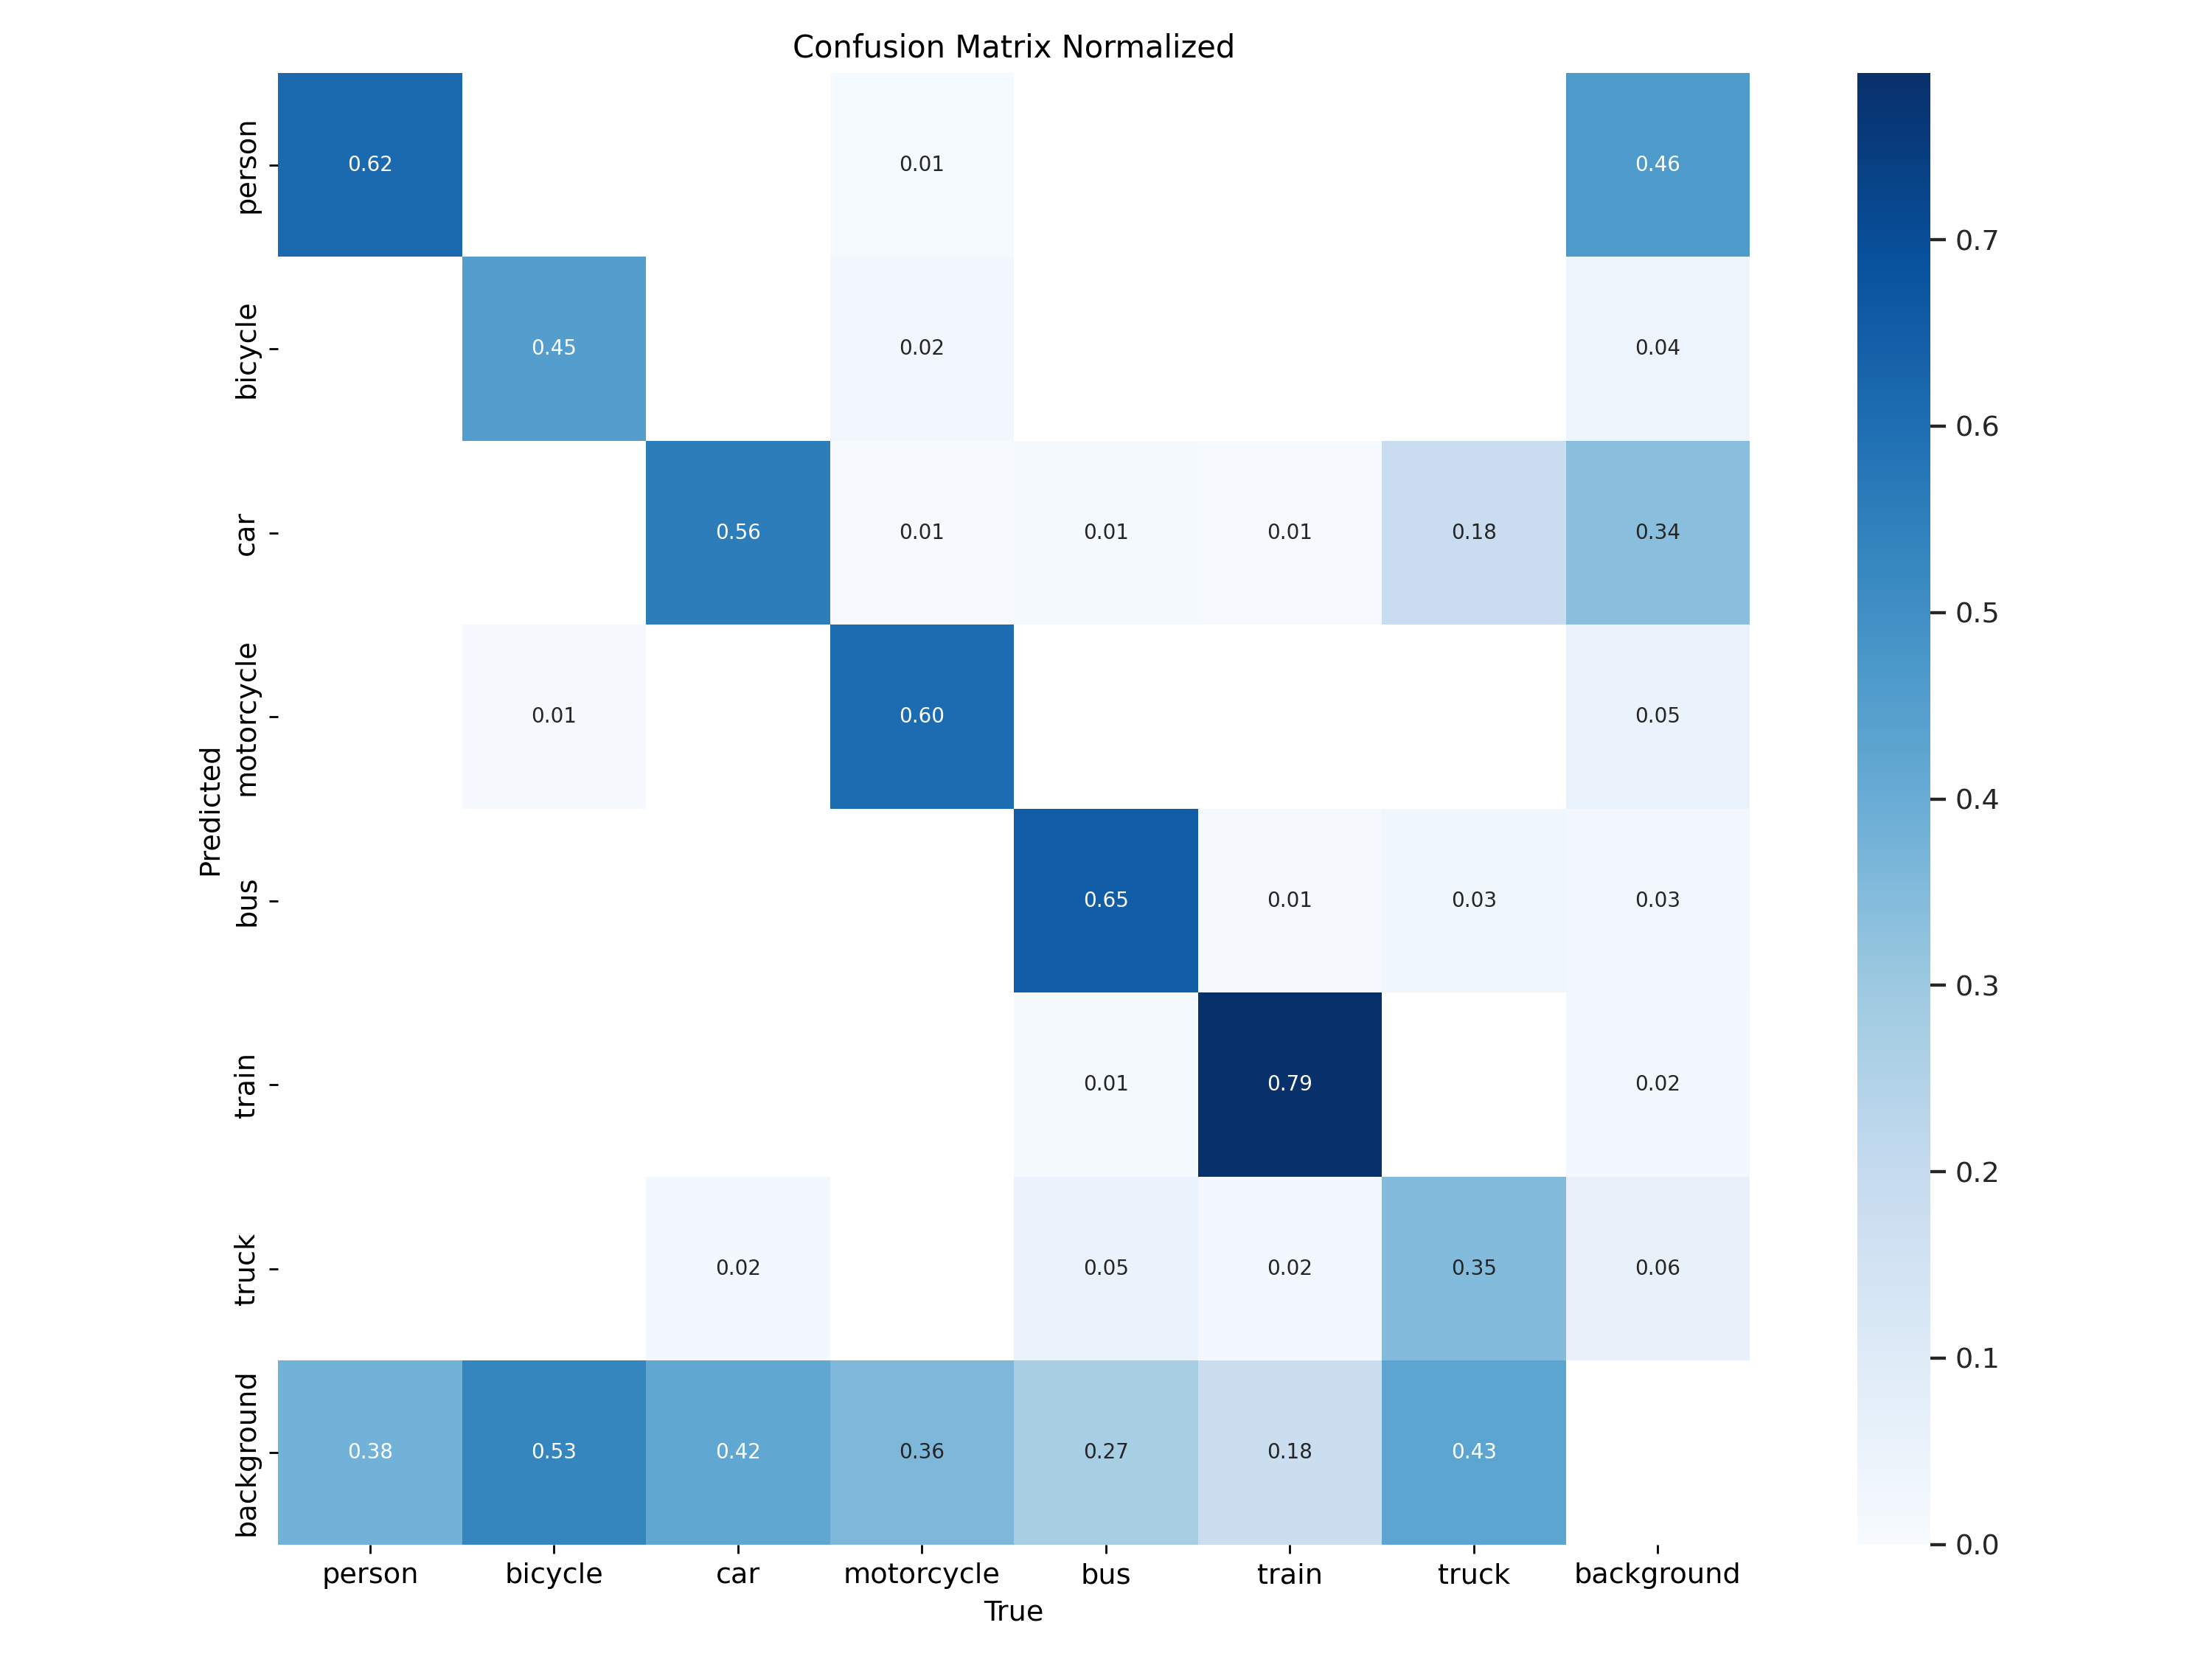

In [30]:
img = Image(os.path.join(results_dir, "confusion_matrix_normalized.png"))
img.width = 1000
display(img)

A good sign are the mostly zero off-diagonal values, indicating good seperation of the classes. The high values in the last row, indicates a lot of false negative, meaning the model overlooks a lot of the instances in a picture. The high values background-person and background-car means that the model is more likely to "hallucinate" a person or a car in an image, while there is no person or car.  

## Validation Batch

To also have a look at some samples, we plotted the prediciton of one validation batch:

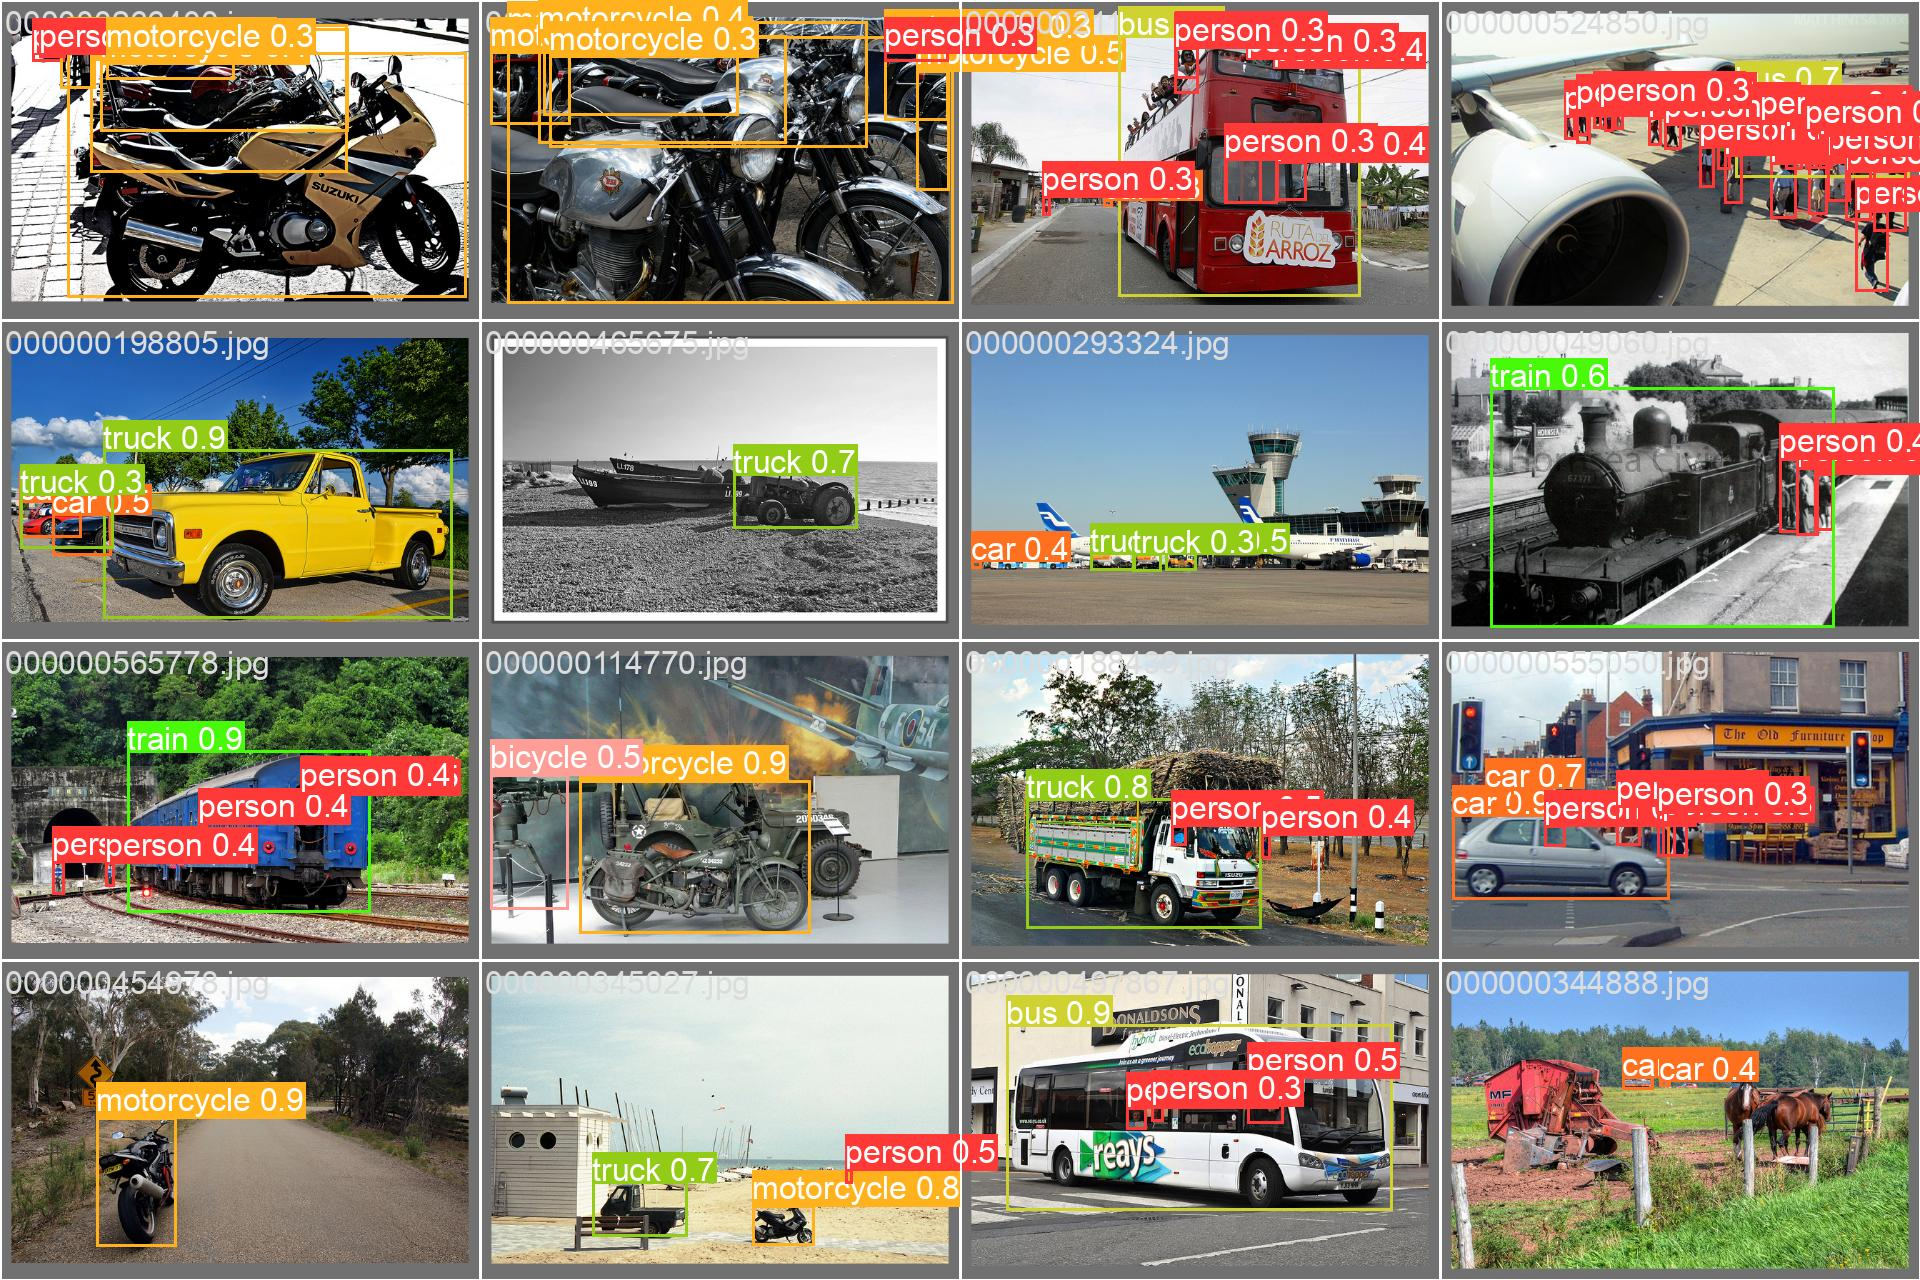

In [31]:
img = Image(os.path.join(results_dir, f"val_batch{1}_pred.jpg"))
img.width = 1600
display(img)

Overall the model has an easy time with big clearly visible objects, but struggles a lot of clutter or realy small details in the background.

# Process Video

source: [Streaming for-loop](https://docs.ultralytics.com/modes/predict/#streaming-source-for-loop)

## Build video from trained model

In [9]:
import cv2
from ultralytics import YOLO
if is_colab_env():
  from google.colab.patches import cv2_imshow

# Load the trained model
model = YOLO(os.path.join(results_dir, "weights", "best.pt"))

# Open the video file
cap = cv2.VideoCapture(VIDEO_PATH)

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()
    if success:
        # Run YOLOv8 inference on the frame
        results = model(frame)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Display the annotated frame
        if is_colab_env():
          cv2_imshow(annotated_frame) # <-- works in colab environment
        else:
          cv2.imshow("YOLOv8 Inference", annotated_frame) # <-- might work locally

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()


0: 384x640 2 cars, 54.7ms
Speed: 3.0ms preprocess, 54.7ms inference, 225.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 4.5ms
Speed: 1.6ms preprocess, 4.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 4.0ms
Speed: 1.8ms preprocess, 4.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5.8ms
Speed: 1.4ms preprocess, 5.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5.9ms
Speed: 2.1ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 4.3ms
Speed: 1.4ms preprocess, 4.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 

## Build video from not fine-tuned model

In [33]:
import cv2
from ultralytics import YOLO
if is_colab_env():
    from google.colab.patches import cv2_imshow

# build a new model from YAML
model = YOLO('yolov8n.pt')

# Open the video file
cap = cv2.VideoCapture(VIDEO_PATH)

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLOv8 inference on the frame
        results = model(frame)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Display the annotated frame
        if is_colab_env():
          cv2_imshow(annotated_frame) # <-- works in colab environment
        else:
          cv2.imshow("YOLOv8 Inference", annotated_frame) # <-- might work locally

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4864dc4af0>
Traceback (most recent call last):
  File "/home/noah/miniconda3/envs/MLoop/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/noah/miniconda3/envs/MLoop/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/noah/miniconda3/envs/MLoop/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/noah/miniconda3/envs/MLoop/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/noah/miniconda3/envs/MLoop/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/noah/miniconda3/envs/MLoop/lib/python3.10/selectors.py", line 416, in select
    fd_event_


0: 384x640 3 cars, 29.6ms
Speed: 1.6ms preprocess, 29.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 6.7ms
Speed: 1.5ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5.

We can observe that both model work, but the fine-tuned version seem to have less random predictions popping up and handles tracking multiples cars/busses better than the original yolov8.  